# 1D problem

In [284]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
import xskillscore as xs
import xarray as xr

In [15]:
tf.__version__

'2.1.0'

In [2]:
sns.set_style('darkgrid')

In [88]:
def create_data(n, sigma):
    x = np.linspace(0, 1, n)
    y_true = np.sin(x) + 0.5*np.sin(10*x)
    y = np.sin(x) + 0.5*np.sin(10*x) + np.random.normal(0, sigma, x.shape)
    return x, y, y_true

In [89]:
x_train, y_train, y_true = create_data(1000, 0.15)
x_valid, y_valid, y_true = create_data(1000, 0.15)

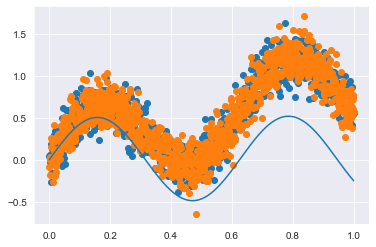

In [87]:
plt.scatter(x_train, y_train)
plt.scatter(x_valid, y_valid)
plt.plot(x_train, y_true);

## Parametric forecast

In [152]:
def crps_loss(y_true, y_pred):
    # Split input
    mu = y_pred[:, 0]
    sigma = y_pred[:, 1]

    # To stop sigma from becoming negative we first have to
    # convert it the the variance and then take the square
    # root again.
    sigma = tf.nn.relu(sigma)

    # The following three variables are just for convenience
    loc = (y_true - mu) / tf.maximum(1e-7, sigma)
    phi = 1.0 / np.sqrt(2.0 * np.pi) * tf.math.exp(-tf.math.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / np.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))

    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps)

In [239]:
class CRPSLoss(tf.keras.losses.Loss):
    """CRPS Loss function for a normal distribution
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, y_true, y_pred):
        
        # Split y_pred into means and standard deviations
        mu = tf.squeeze(y_pred[..., 0])
        sigma = tf.squeeze(y_pred[..., 1])

        # Apply relu to sigma to make sure standard deviations are positive
        sigma = tf.nn.relu(sigma)
        
        # Add epsilon to avoid dividing by zero
        sigma = tf.maximum(1e-7, sigma)

        # Define helper variables for convenience
        loc = (y_true - mu) / sigma
        phi = 1.0 / np.sqrt(2.0 * np.pi) * tf.math.exp(-tf.math.square(loc) / 2.0)
        Phi = 0.5 * (1.0 + tf.math.erf(loc / np.sqrt(2.0)))

        # First we will compute the crps for each input/target pair
        crps = sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / np.sqrt(np.pi))

        return crps

In [241]:
x_train, y_train, y_true2 = create_data(1000, 0.0015)
x_valid, y_valid, y_true2 = create_data(1000, 0.0015)

In [242]:
model = tf.keras.models.Sequential([
    Dense(128, input_shape=(1,)),
    LeakyReLU(),
#     Dense(256, activation='relu'),
#     Dense(256, activation='relu'),
#     Dense(256, activation='relu'),
    Dense(128),
    LeakyReLU(),
    Dense(128),
    LeakyReLU(),
    Dense(128),
    LeakyReLU(),
    Dense(2)
])

In [ ]:
np.stack()

In [243]:
crps_loss = CRPSLoss()

In [244]:
model.compile(tf.keras.optimizers.RMSprop(1e-4), crps_loss)

In [245]:
model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_valid, y_valid), )

Train on 1000 samples, validate on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.5022 - val_loss: 0.4433
Epoch 2/10
1000/1000 [==============================] - 0s 82us/sample - loss: 0.4224 - val_loss: 0.3702
Epoch 3/10
1000/1000 [==============================] - 0s 131us/sample - loss: 0.3660 - val_loss: 0.3081
Epoch 4/10
1000/1000 [==============================] - 0s 191us/sample - loss: 0.3238 - val_loss: 0.2596
Epoch 5/10
1000/1000 [==============================] - 0s 139us/sample - loss: 0.2954 - val_loss: 0.2278
Epoch 6/10
1000/1000 [==============================] - 0s 167us/sample - loss: 0.2795 - val_loss: 0.2121
Epoch 7/10
1000/1000 [==============================] - 0s 128us/sample - loss: 0.2704 - val_loss: 0.2039
Epoch 8/10
1000/1000 [==============================] - 0s 100us/sample - loss: 0.2662 - val_loss: 0.2023
Epoch 9/10
1000/1000 [==============================] - 0s 240us/sample - loss: 0.2623 - val_loss: 0.1992
E

In [234]:
preds = model.predict(x_valid)

In [235]:
preds.shape

(1000, 2)

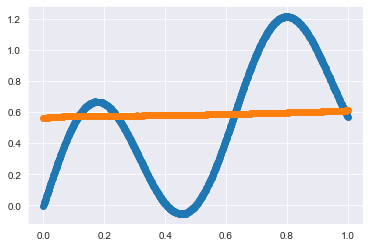

In [237]:
plt.scatter(x_valid, y_valid)
plt.scatter(x_valid, preds[:, 0])

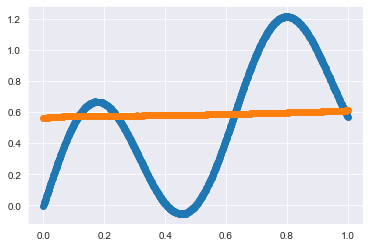

In [238]:
plt.scatter(x_valid, y_valid)
plt.scatter(x_valid, preds[:, 0])

## test time dropout

In [299]:
x_train, y_train, y_true2 = create_data(100000, 0.15)
x_valid, y_valid, y_true2 = create_data(1000, 0.15)

In [300]:
def dropout_net(dr):
    inp = Input(shape=(1))
    x = Dense(128)(inp)
    x = LeakyReLU()(x)
    x = Dropout(dr)(x, training=True)
    x = Dense(128)(x)
    x = LeakyReLU()(x)
    x = Dropout(dr)(x, training=True)
    x = Dense(128)(x)
    x = LeakyReLU()(x)
    x = Dropout(dr)(x, training=True)
    outp = Dense(1)(x)
    model = tf.keras.models.Model(inp, outp)
    return model

In [335]:
model1 = dropout_net(0.25)
model1.compile(tf.keras.optimizers.RMSprop(1e-4), 'mse')

In [339]:
model1.fit(x_train, y_train, batch_size=128, epochs=25, validation_data=(x_valid, y_valid))

Train on 100000 samples, validate on 1000 samples
Epoch 1/25
100000/100000 [==============================] - 4s 36us/sample - loss: 0.0346 - val_loss: 0.0342
Epoch 2/25
100000/100000 [==============================] - 4s 35us/sample - loss: 0.0343 - val_loss: 0.0347
Epoch 3/25
100000/100000 [==============================] - 4s 37us/sample - loss: 0.0340 - val_loss: 0.0348
Epoch 4/25
100000/100000 [==============================] - 4s 43us/sample - loss: 0.0337 - val_loss: 0.0357
Epoch 5/25
100000/100000 [==============================] - 4s 41us/sample - loss: 0.0335 - val_loss: 0.0357
Epoch 6/25
100000/100000 [==============================] - 4s 39us/sample - loss: 0.0333 - val_loss: 0.0325
Epoch 7/25
100000/100000 [==============================] - 4s 37us/sample - loss: 0.0330 - val_loss: 0.0370
Epoch 8/25
100000/100000 [==============================] - 4s 38us/sample - loss: 0.0330 - val_loss: 0.0354
Epoch 9/25
100000/100000 [==============================] - 4s 40us/sample - l

In [340]:
preds1 = model1.predict(x_valid)

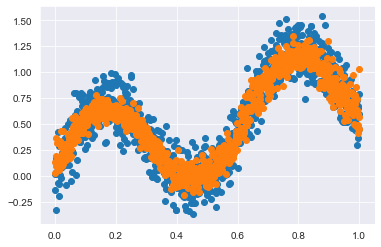

In [341]:
plt.scatter(x_valid, y_valid)
plt.scatter(x_valid, preds1)

In [342]:
model2 = dropout_net(0.5)
model2.compile(tf.keras.optimizers.RMSprop(1e-4), 'mse')

In [344]:
model2.fit(x_train, y_train, batch_size=128, epochs=25, validation_data=(x_valid, y_valid))

Train on 100000 samples, validate on 1000 samples
Epoch 1/25
100000/100000 [==============================] - 4s 35us/sample - loss: 0.0610 - val_loss: 0.0591
Epoch 2/25
100000/100000 [==============================] - 2s 20us/sample - loss: 0.0605 - val_loss: 0.0595
Epoch 3/25
100000/100000 [==============================] - 2s 21us/sample - loss: 0.0593 - val_loss: 0.0624
Epoch 4/25
100000/100000 [==============================] - 2s 20us/sample - loss: 0.0587 - val_loss: 0.0596
Epoch 5/25
100000/100000 [==============================] - 2s 20us/sample - loss: 0.0581 - val_loss: 0.0645
Epoch 6/25
100000/100000 [==============================] - 2s 21us/sample - loss: 0.0573 - val_loss: 0.0597
Epoch 7/25
100000/100000 [==============================] - 2s 24us/sample - loss: 0.0571 - val_loss: 0.0588
Epoch 8/25
100000/100000 [==============================] - 3s 27us/sample - loss: 0.0562 - val_loss: 0.0547
Epoch 9/25
100000/100000 [==============================] - 2s 22us/sample - l

In [345]:
preds2 = model2.predict(x_valid)

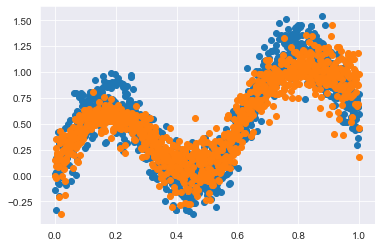

In [346]:
plt.scatter(x_valid, y_valid)
plt.scatter(x_valid, preds2)

In [347]:
nens = 100
ens1 = np.concatenate([model1.predict(x_valid) for _ in range(20)], -1)
ens2 = np.concatenate([model2.predict(x_valid) for _ in range(20)], -1)

In [348]:
ens1 = xr.DataArray(ens1, dims=['sample', 'member'])
ens2 = xr.DataArray(ens2, dims=['sample', 'member'])

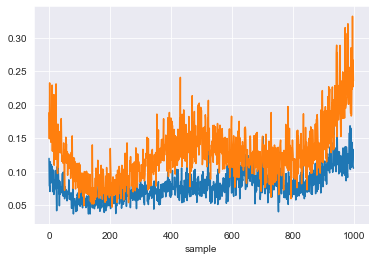

In [349]:
ens1.std('member').plot()
ens2.std('member').plot()

In [350]:
y_xr = xr.DataArray(y_valid, dims=['sample'])

In [351]:
xs.crps_ensemble(y_xr, ens1).mean()

<xarray.DataArray ()>
array(0.09790601)

In [352]:
xs.crps_ensemble(y_xr, ens2).mean()

<xarray.DataArray ()>
array(0.11193036)

In [353]:
from scipy.stats import rankdata
def ranker(obs_array,Ensemble):
    """Compute the rank histogram rankings
    obs_array = np.array[time,];           e.g. obs_array.shape = (136884,)
    Ensemble = np.array([Ensemble,time]);  e.g. Ensemble.shape  = (15, 136884)
     """
    combined=np.vstack((np.array(obs_array)[np.newaxis],Ensemble))
    print('computing ranks')
    ranks=np.apply_along_axis(lambda x: rankdata(x,method='min'),0,combined)

    print('computing ties')
    ties=np.sum(ranks[0]==ranks[1:], axis=0)
    ranks=ranks[0]
    
    return ranks

In [354]:
rank1 = ranker(y_valid, ens1.T)
rank2 = ranker(y_valid, ens2.T)

computing ranks
computing ties
computing ranks
computing ties


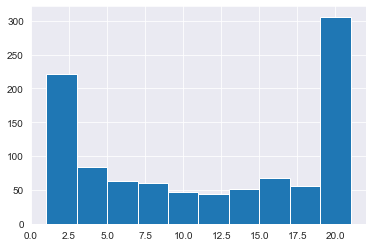

In [355]:
plt.hist(rank1);

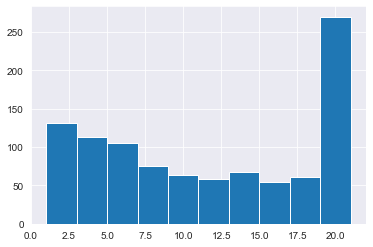

In [356]:
plt.hist(rank2);

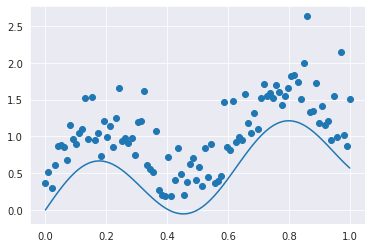

In [ ]:
# Skewed
y = np.sin(x) + 0.5*np.sin(10*x) + np.random.gamma(3, 0.15, x.shape)
plt.scatter(x, y)
plt.plot(x, y_true);

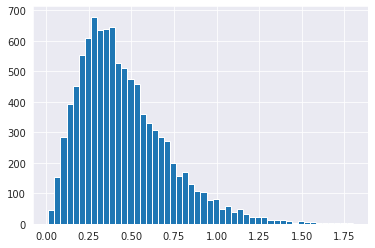

In [ ]:
plt.hist(np.random.gamma(3, 0.15, 10000), bins=50);

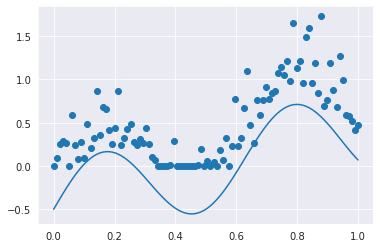

In [ ]:
# Truncated
y = -0.5 + np.sin(x) + 0.5*np.sin(10*x) + np.random.gamma(3, 0.15, x.shape)
y = np.maximum(y, 0)
plt.scatter(x, y)
plt.plot(x, y_true-0.5);

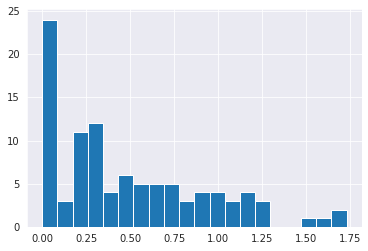

In [ ]:
plt.hist(y, bins=20);

In [ ]:
# Bimodal
y = np.sin(x) + 0.5*np.sin(10*x) + ???
plt.scatter(x, y)
plt.plot(x, y_true);

## 2D example

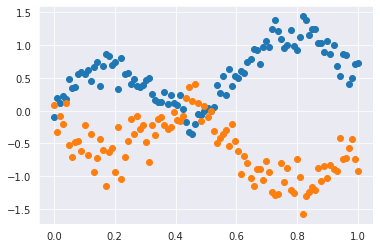

In [ ]:
# Gaussian
y1 = np.sin(x) + 0.5*np.sin(10*x) + np.random.normal(0, 0.15, x.shape)
y2 = -y1 + np.random.normal(0, 0.15, x.shape)
plt.scatter(x, y1)
plt.scatter(x, y2)

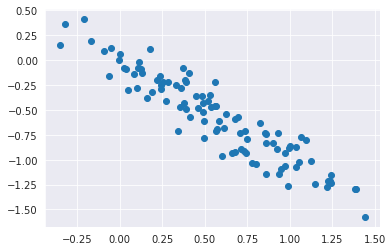

In [ ]:
plt.scatter(y1, y2)